# Handwritten Digits Classifier
In this project, we will implement models to classify handwritten digits. We will use the data hosted on the UCI Machine Learning Repository:
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Conventiently, these data are already hosted in Scikit-learn's library.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
%matplotlib inline

In [2]:
# import data
digit_data = load_digits()

# get keys
digit_data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
# extract labels and data and convert to pandas DF
labels = pd.Series(digit_data['target'])
data = pd.DataFrame(digit_data['data'])

## Data Exploration
Each image is represented as a row of pixel values. To visualize the images, we need to reshape it to its original dimensions and plot the coordinates.

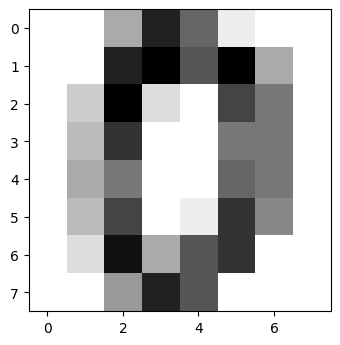

In [4]:
# reshape and plot the first image as an example
ex_image = data.iloc[0]
np_image = ex_image.values
np_image = np_image.reshape(8,8)
plt.imshow(np_image, cmap='gray_r')

For our human minds, it's pretty easy to identify this as a zero. But how easy will it be for a machine?
Let's look at some more digits:

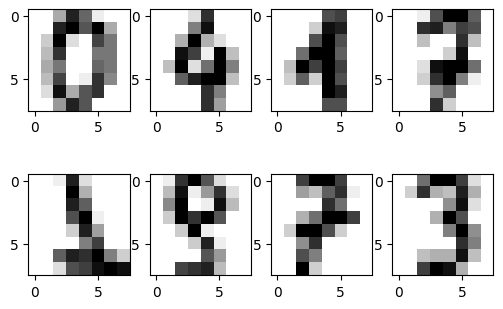

In [5]:
# reshape and plot more examples
first_row = [0,100,200,300]
second_row = [1000,1100,1200,1300]

f, axarr = plt.subplots(2,4)

for i in range(len(first_row)):
    axarr[0, i].imshow(data.iloc[first_row[i]].values.reshape(8,8), cmap='gray_r')
    axarr[1, i].imshow(data.iloc[second_row[i]].values.reshape(8,8), cmap='gray_r')

plt.show()

Some images are not so easy to tell! Maybe our machines will perform better than our human minds after all...

## K Nearest Neighbors Model

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# Trains knn model on features and labels from training set with n neighbors
def train_knn(k, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(train_features, train_labels)
    return knn

# Tests knn model with test features and reports model accuracy using real labels
def test_knn(knn, test_features, test_labels):
    tester_df = pd.DataFrame()
    predictions = knn.predict(test_features)
    tester_df['true'] = test_labels
    tester_df['pred'] = predictions
    return (tester_df['pred']==tester_df['true']).mean()

# performs k-fold cross validation with 4 folds using train and test functions. Records accuracy
# of each fold
def cross_validate_knn(k):
    kf = KFold(n_splits = 4, shuffle = True)
    fold_accs = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        knn = train_knn(k, train_features, train_labels)
        fold_accs.append(test_knn(knn, test_features, test_labels))
        
    return fold_accs

knn_one_accuracies = cross_validate_knn(1)
np.mean(knn_one_accuracies)


0.9888728037614452

The K-nearest neighbors model achieves an average of 98.89% accuracy. This is already quite successful, but let's see how the number of nearest neighbors influences accuracy.

### Hyperparameter optimization

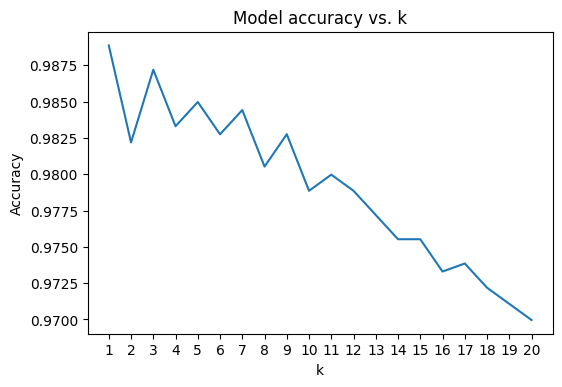

In [12]:
# iterate k from 1 to 20
k_range = np.arange(1,21)
accuracies = [np.mean(cross_validate_knn(k)) for k in k_range]

plt.plot(k_range,accuracies)
plt.title('Model accuracy vs. k')
plt.xlabel('k')
plt.xticks(k_range)
plt.ylabel('Accuracy')
plt.show()

The most accurate model uses only one nearest-neighbor.

## Neural Network With One Hidden Layer
Although quite accurate here, the KNN uses high memory and does not have a representation we can debug. 
Let's implement a neural network to classify the data.

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

# trains neural network with one hidden layer of n_a architecture
def train_nn(n_a, train_features, train_labels):
    nn = MLPClassifier(hidden_layer_sizes = n_a)
    nn.fit(train_features, train_labels)
    return nn

# tests neural network and returns overall accuracy
def test_nn(nn, test_features, test_labels):
    predictions = nn.predict(test_features)
    tester_df = pd.DataFrame()
    tester_df['true'] = test_labels
    tester_df['pred'] = predictions
    return np.mean(tester_df['true'] == tester_df['pred'])

# implements 4-fold cross validation, takes in architecture for neural network
def cross_validate_knn(n_a):
    kf = KFold(n_splits = 4, shuffle = True)
    fold_accs = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        nn = train_nn(n_a, train_features, train_labels)
        fold_accs.append(test_nn(nn, test_features, test_labels))
    return fold_accs

### Hyperparameter Optimization
We are going to iterate through 6 different models, increasing the number of neurons but leaving the number of hidden layers to one. We will compare the overall accuracy of each model.

In [18]:
n_neurons = [8,16,32,64,128,256]
accuracies = [np.mean(cross_validate_knn((n_neurons[i],))) for i in range(6)]    

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

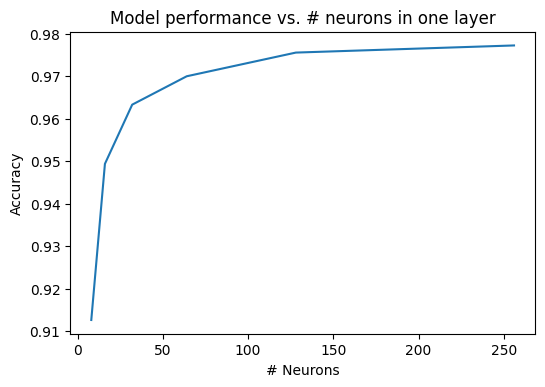

In [20]:
# visualize results
plt.plot(n_neurons, accuracies)
plt.xlabel('# Neurons')
plt.ylabel('Accuracy')
plt.title('Model performance vs. # neurons in one layer')
plt.show()

Model performance with one layer converges under 98%, so we do not see an advantage over KNN with this implementation. We can see that adding neurons significantly improved accuracy, so let's see how adding layers impacts performance.

## Neural Network with Two Layers
We will train three networks with two layers, incrementing the number of neurons. To save computational time we will use 64, 128, then 256 neurons in each layer.

In [23]:
n_neurons = [64,128,256]
accuracies = [np.mean(cross_validate_knn((n_neurons[i],n_neurons[i]))) for i in range(3)] 

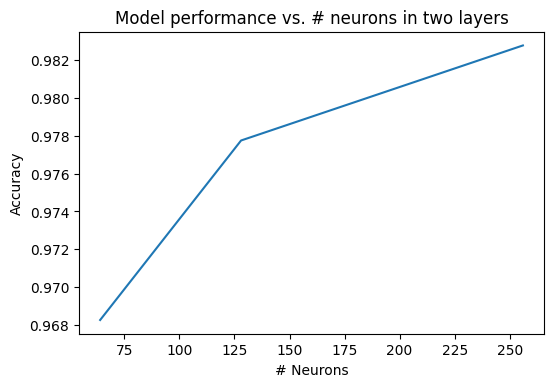

In [24]:
# visualize results
plt.plot(n_neurons, accuracies)
plt.xlabel('# Neurons')
plt.ylabel('Accuracy')
plt.title('Model performance vs. # neurons in two layers')
plt.show()

In [25]:
print('With two layers of 256 neurons each, our model achieves an accuracy of {}'.format(accuracies[2]))

With two layers of 256 neurons each, our model achieves an accuracy of 0.9827505567928729


The model is better but still does not surpass the KNN model. 

## Neural Network with Three Layers
Let's add one more layer, but to reduce overfitting, increase the cross-validation folds to 6.

In [26]:
# implements 6-fold cross validation, takes in architecture for neural network
def cross_validate_knn(n_a):
    kf = KFold(n_splits = 6, shuffle = True)
    fold_accs = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        nn = train_nn(n_a, train_features, train_labels)
        fold_accs.append(test_nn(nn, test_features, test_labels))
    return fold_accs

In [27]:
n_neurons = [10, 64, 128]
accuracies = [np.mean(cross_validate_knn((n_neurons[i],n_neurons[i],n_neurons[i]))) for i in range(3)]

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

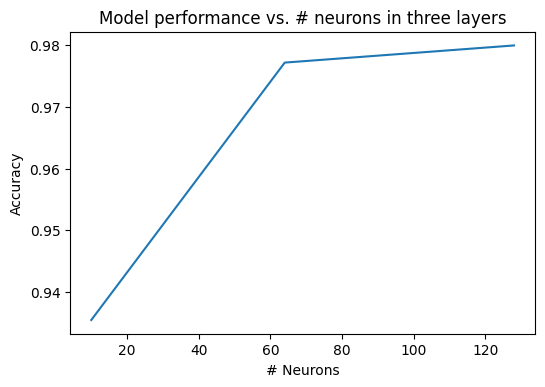

In [28]:
# visualize results
plt.plot(n_neurons, accuracies)
plt.xlabel('# Neurons')
plt.ylabel('Accuracy')
plt.title('Model performance vs. # neurons in three layers')
plt.show()

In [29]:
print('With three layers of 128 neurons each, our model achieves an accuracy of {}'.format(accuracies[2]))

With three layers of 128 neurons each, our model achieves an accuracy of 0.9799646971386103


The three-layer model also appears to converge on 98% accuracy, so it doesn't add much. It would probably be faster to implement KNN for this problem since we would not sacrifice accuracy.